# Demo of pmatrix and dmatrix
This notebook demonstrates basic functionality of `Pmatrix` and `Dmatrix` using toy data.

## Pmatrix

`Pmatrix` computes the **ground truth** for training. It takes a wall section image (`.jpg`) where **stone** and **mortar** are identified by their RGB colors, defined in the `Colores` dictionary in `config.py`. The function outputs a **grayscale "purity" map** (with values from 0 = stone to 1 = mortar) and a **binary version** thresholded at 0.5. Each output is returned both as a 2D array (for visualization) and a flattened 1D array (to align with the neural network's input structure). These outputs serve as the **target labels** for training.


In [12]:
# ALWAYS RUN THIS. This block is so we can import from other folders

import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
sys.path.append(str(project_root))

# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tempfile
import pandas as pd

from common.config import SECTIONS_DIR, RAYS_DIR, dims
from common.pmatrix import Pmatrix, tensor_pmatrix
from common.dmatrix import load_ray_tensor


The following code showcases the `Pmatrix` class.

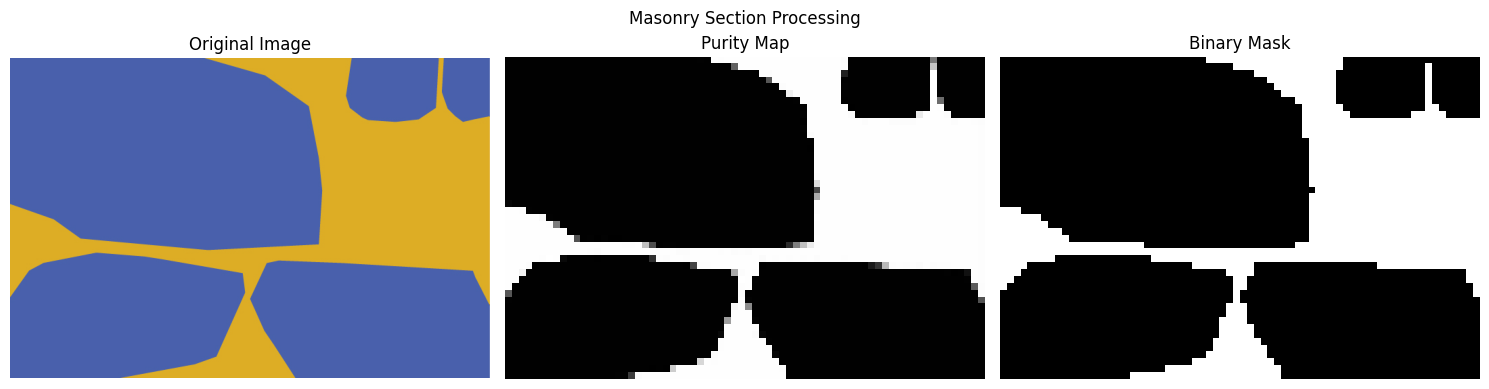

In [2]:
# Load and process image
img_path = Path(SECTIONS_DIR) / "01.jpg"
img_bgr = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Compute reduced dimensions
height, width = img_bgr.shape[:2]
Dx, Dy = width // 10, height // 10

# Get purity and binary mask
P, _, Pbin, _ = Pmatrix(img_path, Dx, Dy)

# Plot everything in one sharp figure
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(img_rgb)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(P, cmap="gray", interpolation="nearest")  # Keep sharp edges
axs[1].set_title("Purity Map")
axs[1].axis("off")

axs[2].imshow(Pbin, cmap="gray", interpolation="nearest")
axs[2].set_title("Binary Mask")
axs[2].axis("off")

plt.suptitle("Masonry Section Processing")
plt.tight_layout()
plt.show()


There is also a parallelized version faster for groups of images (`tensor_matrix`). This code converts all images in the `sections` folder, but only shows the first 3.

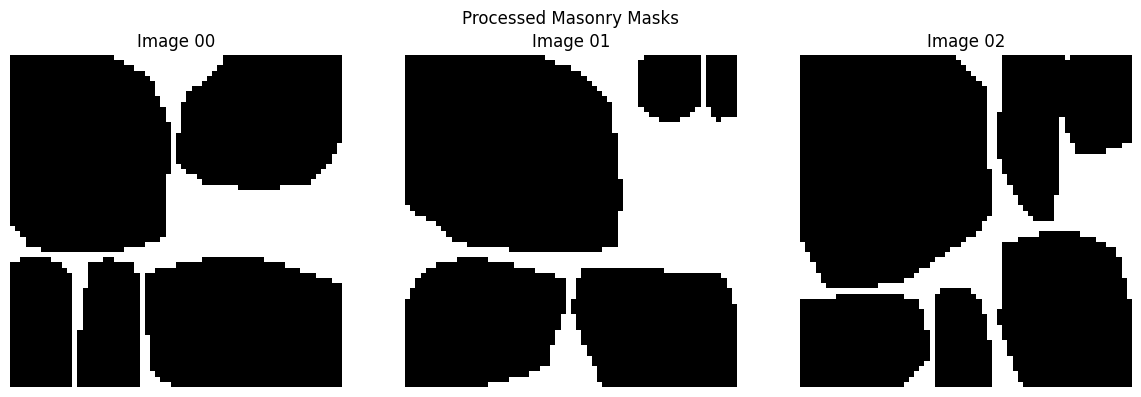

In [3]:
# Settings
folder = Path(SECTIONS_DIR)
nx, ny = 64, 64               # Resize target
binary = True                 # Use binary mask or grayscale (CHANGE THIS TO SEE)
max_images = 3                # How many to show
skip_list = []                # Optional: skip indices like [3, 7]

# Load all processed images into a tensor
files, tensor = tensor_pmatrix(
    folder=folder,
    nx=nx, ny=ny,
    binary=binary,
    skips=skip_list
)

# Plot the first N results in a grid
num_images = min(max_images, tensor.shape[0])
cols = 3
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axs = axs.flatten()

for i in range(num_images):
    axs[i].imshow(tensor[i], cmap="gray", interpolation="nearest")
    axs[i].set_title(f"Image {files[i].stem}")
    axs[i].axis("off")

# Turn off unused subplots
for j in range(num_images, len(axs)):
    axs[j].axis("off")

plt.suptitle("Processed Masonry Masks" if binary else "Processed Masonry Purity Maps")
plt.tight_layout()
plt.show()


# Dmatrix

**`dmatrix`** computes how much distance each acoustic ray travels through each voxel in the simulation grid, forming the input matrix for tomographic reconstruction.


The **first code snippet** shows a toy example with three made-up rays passing through a simple voxel grid to intuitively visualize the ray-voxel interactions.

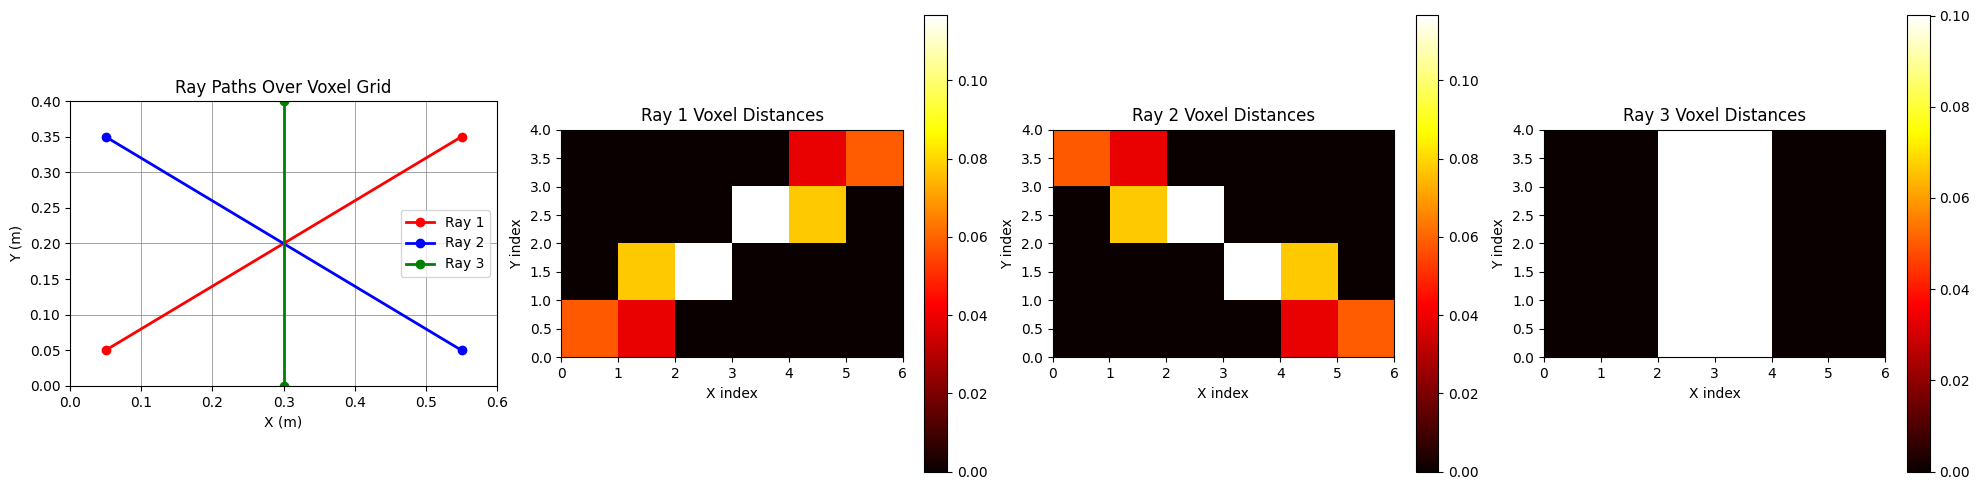

In [15]:
# === STEP 1: Create a made-up demo file ===
# Each ray is a line segment from emitter to receiver, with known physical properties
# Units: positions in meters, velocity in m/s, frequency in kHz

# Ray format:
# [RayID, Xe, Ye, Ze, Xr, Yr, Zr, Velocity, Amplitude, Frequency]
demo_rays = [
    [1, 0.05, 0.05, 0.0, 0.55, 0.35, 0.0, 1500.0, 0.8, 30.0],  # Diagonal (bottom-left to top-right)
    [2, 0.55, 0.05, 0.0, 0.05, 0.35, 0.0, 1200.0, 0.6, 25.0],  # Diagonal (bottom-right to top-left)
    [3, 0.30, 0.00, 0.0, 0.30, 0.40, 0.0, 1000.0, 1.0, 20.0],  # Vertical through center
]
demo_df = pd.DataFrame(demo_rays)
demo_path = Path("ray_demo.txt")
demo_df.to_csv(demo_path, sep="\t", index=False, header=False)

# === STEP 2: Define grid resolution ===
nx, ny = 6, 4     # number of voxels in x and y direction
pad = 0
include_edges = True

# === STEP 3: Load voxel-ray intersection data ===
D, params, used_dims = load_ray_tensor(
    filepath=str(demo_path),
    nx=nx, ny=ny, nz=0,
    pad=pad,
    include_edges=include_edges
)

# === STEP 4: Plot everything together ===
fig, axes = plt.subplots(1, D.shape[-1] + 1, figsize=(5 * (D.shape[-1] + 1), 5))

# Plot rays on voxel grid
ax = axes[0]
xmin, xmax = used_dims[0]
ymin, ymax = used_dims[1]
dx = (xmax - xmin) / nx
dy = (ymax - ymin) / ny

# Draw grid lines
for i in range(nx + 1):
    x = xmin + i * dx
    ax.plot([x, x], [ymin, ymax], color="gray", lw=0.5)
for j in range(ny + 1):
    y = ymin + j * dy
    ax.plot([xmin, xmax], [y, y], color="gray", lw=0.5)

# Plot ray paths
colors = ["red", "blue", "green"]
for idx, ray in enumerate(demo_rays):
    _, xe, ye, _, xr, yr, _, *_ = ray
    ax.plot([xe, xr], [ye, yr], label=f"Ray {idx+1}", color=colors[idx], lw=2, marker='o')

ax.set_title("Ray Paths Over Voxel Grid")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
ax.legend()

# Plot D matrix (distance per voxel) for each ray
for i in range(D.shape[-1]):
    ax = axes[i + 1]
    dist_map = D[..., i]
    im = ax.imshow(
        dist_map.T,           # transpose so X=cols, Y=rows
        origin="lower",
        cmap="hot",
        extent=[0, nx, 0, ny],
        interpolation="nearest",
        aspect='equal'
    )
    ax.set_title(f"Ray {i+1} Voxel Distances")
    ax.set_xlabel("X index")
    ax.set_ylabel("Y index")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()



The **second code snippet** loads real ray data from `ray00.txt` and visua

C:\Users\Equipo\AppData\Local\Temp\ipykernel_20320\3516881765.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_rays_to_plot)


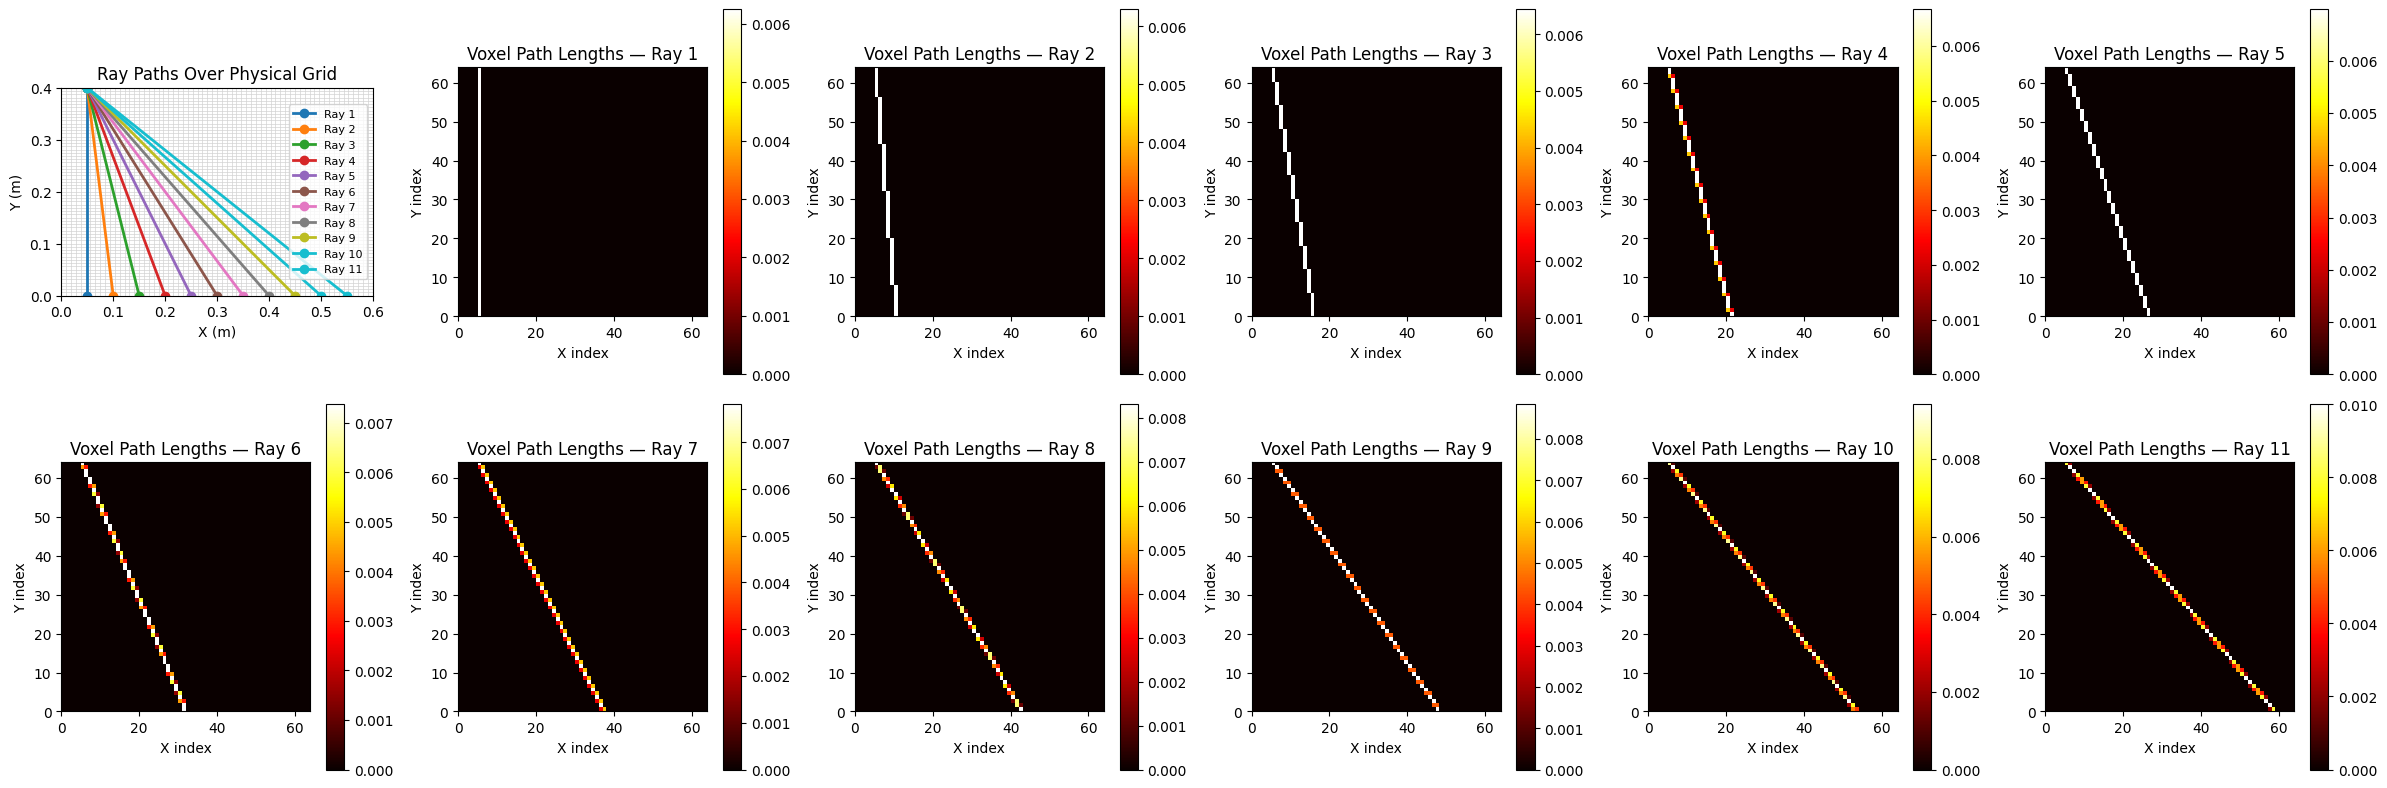

In [17]:
# === Load the ray file ===
filename = "ray00.txt"
ray_file = Path(RAYS_DIR) / filename

# === Grid resolution and voxel settings ===
nx, ny = 64, 64
nz = 0
pad = 0
include_edges = True

# === Load distance matrix, ray parameters, and dims ===
D, params, used_dims = load_ray_tensor(
    filepath=str(ray_file),
    nx=nx, ny=ny, nz=nz,
    pad=pad,
    include_edges=include_edges
)

# === Load full dataframe with positions for plotting rays ===
COLUMNS = ["RayID", "Xe", "Ye", "Ze", "Xr", "Yr", "Zr", "Velocity", "Amplitude", "Frequency"]
df = pd.read_csv(ray_file, sep="\t", names=COLUMNS)

# === Select first 11 rays to visualize ===
num_rays_to_plot = 11
df = df.iloc[:num_rays_to_plot]

# === Setup figure ===
fig, axes = plt.subplots(2, 6, figsize=(24, 8))  # 1 for ray paths + 11 heatmaps
axes = axes.flatten()

# === Physical ray paths over grid (leftmost plot) ===
ax = axes[0]
xmin, xmax = used_dims[0]
ymin, ymax = used_dims[1]
dx = (xmax - xmin) / nx
dy = (ymax - ymin) / ny

# Plot voxel grid lines
for i in range(nx + 1):
    x = xmin + i * dx
    ax.plot([x, x], [ymin, ymax], color="lightgray", lw=0.5)
for j in range(ny + 1):
    y = ymin + j * dy
    ax.plot([xmin, xmax], [y, y], color="lightgray", lw=0.5)

# Plot each ray path
colors = plt.cm.get_cmap("tab10", num_rays_to_plot)
for i, row in df.iterrows():
    ax.plot([row.Xe, row.Xr], [row.Ye, row.Yr],
            label=f"Ray {int(row.RayID)}", color=colors(i),
            marker='o', lw=2)

ax.set_title("Ray Paths Over Physical Grid")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")
ax.legend(fontsize=8)

# === Voxel intersection heatmaps for each ray ===
for i in range(num_rays_to_plot):
    ax = axes[i + 1]
    ray_distances = D[..., i]
    im = ax.imshow(ray_distances.T, origin="lower", cmap="hot",
                   extent=[0, nx, 0, ny], interpolation="nearest", aspect="equal")
    ax.set_title(f"Voxel Path Lengths — Ray {i+1}")
    ax.set_xlabel("X index")
    ax.set_ylabel("Y index")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()